In this part I use the previous model and train it, i integrate more parameters for make the model more precise and avoidng overfitting by a cross validation with Kfold stratiffier 

In [1]:
import cudf
import cuml
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
top_features = ['R_1', 'D_48', 'D_74', 'B_19', 'B_8', 'B_38', 'B_20', 'D_62', 'D_45', 'B_22', 
                'S_3', 'B_9', 'S_25', 'B_37', 'B_11', 'P_2', 'R_3', 'D_78', 'S_7', 'D_44', 
                'B_1', 'D_43', 'D_77', 'B_7', 'B_33', 'D_70', 'B_16', 'D_75', 'R_2', 'B_17', 
                'D_55', 'B_2', 'D_58', 'B_4', 'B_30', 'B_3', 'D_61', 'B_18', 'D_47', 'B_23', 'code', 'target']


In [3]:
# Load data from the Parquet file, selecting only relevant columns
df = cudf.read_parquet('df.parquet', columns=top_features)

In [4]:
# Select target and features
y = df['target']
X = df.drop('target', axis=1)

In [5]:
# Check for missing features
miss = set(X.columns) - set(top_features)
print(f'Missing features: {miss}')

Missing features: set()


In [6]:
# Define the StratifiedKFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True)


In [7]:
# Convert cuDF DataFrame to pandas for compatibility with KFold
X = X.to_pandas().values
y = y.to_pandas().values

In [8]:
# Calculate scale_pos_weight based on class distribution
number_of_negative_samples = (y == 0).sum()
number_of_positive_samples = (y == 1).sum()
scale_pos_weight = number_of_negative_samples / number_of_positive_samples
print(f"Scale_pos_weight: {scale_pos_weight}")

Scale_pos_weight: 3.0144970240276834


In [9]:
# Initialize lists to store metrics for plotting
logloss_values = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

In [10]:
# Define model parameters, including eval_metric in the params dictionary
params = {
    'max_depth': 4,
    'learning_rate': 0.05,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight,
    'gamma': 0.1,
    'min_child_weight': 1,
    'eval_metric': 'logloss' 
}

In [11]:

# Loop over KFold splits for importance feature
fold_number = 1
for train_index, test_index in kf.split(X, y):
    # Indexing
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # Create DMatrix for training and testing
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dtest = xgb.DMatrix(X_test_fold, label=y_test_fold)
    
    # Define eval_set for tracking log loss during training
    evals = [(dtrain, 'train'), (dtest, 'validation')]
    
    # Train the model with early stopping
    evals_result = {}
    xgb_model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=100
    )
    
   # Capture log loss values in a DataFrame
    logloss_values.append(evals_result['validation']['logloss'])
    
    
    # Predict on the test fold
    y_pred_fold_prob = xgb_model.predict(dtest)
    
    # Convert probabilities to binary predictions (using 0.5 as the threshold)
    y_pred_fold = (y_pred_fold_prob > 0.5).astype(int)

    # Calculate metrics for this fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, zero_division=1)
    recall = recall_score(y_test_fold, y_pred_fold, zero_division=1)
    f1 = f1_score(y_test_fold, y_pred_fold, zero_division=1)

    # Append metrics to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Print metrics for the current fold
    print(f'Fold {fold_number} Accuracy: {accuracy:.4f}')
    print(f'Fold {fold_number} Precision: {precision:.4f}')
    print(f'Fold {fold_number} Recall: {recall:.4f}')
    print(f'Fold {fold_number} F1 Score: {f1:.4f}')
    print(confusion_matrix(y_test_fold, y_pred_fold))
    print(classification_report(y_test_fold, y_pred_fold, target_names=['Non-Fraud', 'Fraud']))
    
    fold_number += 1

# Calculate and print average metrics
print(f'Average Accuracy: {np.mean(accuracies):.4f}')
print(f'Average Precision: {np.mean(precisions):.4f}')
print(f'Average Recall: {np.mean(recalls):.4f}')
print(f'Average F1 Score: {np.mean(f1_scores):.4f}')


/home/simon/miniconda3/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:33:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.66778	validation-logloss:0.66777
[100]	train-logloss:0.35085	validation-logloss:0.35099
[200]	train-logloss:0.34314	validation-logloss:0.34334
[300]	train-logloss:0.33994	validation-logloss:0.34021
[400]	train-logloss:0.33790	validation-logloss:0.33827
[500]	train-logloss:0.33651	validation-logloss:0.33699
[600]	train-logloss:0.33540	validation-logloss:0.33597
[700]	train-logloss:0.33450	validation-logloss:0.33518
[800]	train-logloss:0.33377	validation-logloss:0.33455
[900]	train-logloss:0.33308	validation-logloss:0.33396
[999]	train-logloss:0.33251	validation-logloss:0.33348
Fold 1 Accuracy: 0.8446
Fold 1 Precision: 0.6315
Fold 1 Recall: 0.9029
Fold 1 F1 Score: 0.7432
[[685545 145172]
 [ 26770 248804]]
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.83      0.89    830717
       Fraud       0.63      0.90      0.74    275574

    accuracy                           0.84   1106291
   macro avg       0.80      0.86      0.82   110

/home/simon/miniconda3/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.66781	validation-logloss:0.66781
[100]	train-logloss:0.35086	validation-logloss:0.35111
[200]	train-logloss:0.34316	validation-logloss:0.34367
[300]	train-logloss:0.33987	validation-logloss:0.34057
[400]	train-logloss:0.33791	validation-logloss:0.33876
[500]	train-logloss:0.33657	validation-logloss:0.33752
[600]	train-logloss:0.33544	validation-logloss:0.33650
[700]	train-logloss:0.33459	validation-logloss:0.33576
[800]	train-logloss:0.33381	validation-logloss:0.33508
[900]	train-logloss:0.33313	validation-logloss:0.33450
[999]	train-logloss:0.33250	validation-logloss:0.33397
Fold 2 Accuracy: 0.8447
Fold 2 Precision: 0.6317
Fold 2 Recall: 0.9026
Fold 2 F1 Score: 0.7433
[[685707 145010]
 [ 26836 248737]]
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.83      0.89    830717
       Fraud       0.63      0.90      0.74    275573

    accuracy                           0.84   1106290
   macro avg       0.80      0.86      0.82   110

/home/simon/miniconda3/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:41:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.66780	validation-logloss:0.66782
[100]	train-logloss:0.35068	validation-logloss:0.35147
[200]	train-logloss:0.34305	validation-logloss:0.34407
[300]	train-logloss:0.33982	validation-logloss:0.34098
[400]	train-logloss:0.33787	validation-logloss:0.33912
[500]	train-logloss:0.33651	validation-logloss:0.33788
[600]	train-logloss:0.33534	validation-logloss:0.33682
[700]	train-logloss:0.33440	validation-logloss:0.33598
[800]	train-logloss:0.33361	validation-logloss:0.33529
[900]	train-logloss:0.33295	validation-logloss:0.33475
[999]	train-logloss:0.33237	validation-logloss:0.33426
Fold 3 Accuracy: 0.8443
Fold 3 Precision: 0.6311
Fold 3 Recall: 0.9024
Fold 3 F1 Score: 0.7427
[[685323 145393]
 [ 26894 248680]]
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.82      0.89    830716
       Fraud       0.63      0.90      0.74    275574

    accuracy                           0.84   1106290
   macro avg       0.80      0.86      0.82   110

/home/simon/miniconda3/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:44:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.66778	validation-logloss:0.66777
[100]	train-logloss:0.35084	validation-logloss:0.35046
[200]	train-logloss:0.34315	validation-logloss:0.34278
[300]	train-logloss:0.33994	validation-logloss:0.33968
[400]	train-logloss:0.33797	validation-logloss:0.33782
[500]	train-logloss:0.33658	validation-logloss:0.33654
[600]	train-logloss:0.33547	validation-logloss:0.33554
[700]	train-logloss:0.33463	validation-logloss:0.33479
[800]	train-logloss:0.33386	validation-logloss:0.33412
[900]	train-logloss:0.33315	validation-logloss:0.33350
[999]	train-logloss:0.33257	validation-logloss:0.33302
Fold 4 Accuracy: 0.8448
Fold 4 Precision: 0.6320
Fold 4 Recall: 0.9020
Fold 4 F1 Score: 0.7433
[[685992 144724]
 [ 27002 248572]]
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.83      0.89    830716
       Fraud       0.63      0.90      0.74    275574

    accuracy                           0.84   1106290
   macro avg       0.80      0.86      0.82   110

/home/simon/miniconda3/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:47:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.66779	validation-logloss:0.66781
[100]	train-logloss:0.35075	validation-logloss:0.35112
[200]	train-logloss:0.34322	validation-logloss:0.34368
[300]	train-logloss:0.33988	validation-logloss:0.34041
[400]	train-logloss:0.33790	validation-logloss:0.33849
[500]	train-logloss:0.33653	validation-logloss:0.33722
[600]	train-logloss:0.33544	validation-logloss:0.33623
[700]	train-logloss:0.33451	validation-logloss:0.33541
[800]	train-logloss:0.33377	validation-logloss:0.33477
[900]	train-logloss:0.33314	validation-logloss:0.33424
[999]	train-logloss:0.33253	validation-logloss:0.33374
Fold 5 Accuracy: 0.8445
Fold 5 Precision: 0.6314
Fold 5 Recall: 0.9025
Fold 5 F1 Score: 0.7430
[[685530 145186]
 [ 26880 248694]]
              precision    recall  f1-score   support

   Non-Fraud       0.96      0.83      0.89    830716
       Fraud       0.63      0.90      0.74    275574

    accuracy                           0.84   1106290
   macro avg       0.80      0.86      0.82   110

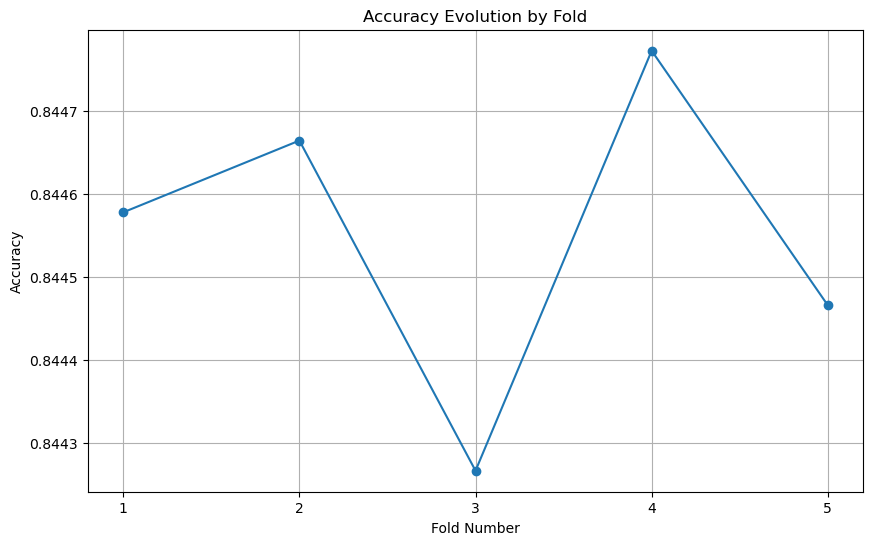

In [12]:
# Plot the accuracy evolution by fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution by Fold')
plt.grid(True)
plt.xticks(range(1, len(accuracies) + 1))
plt.show()

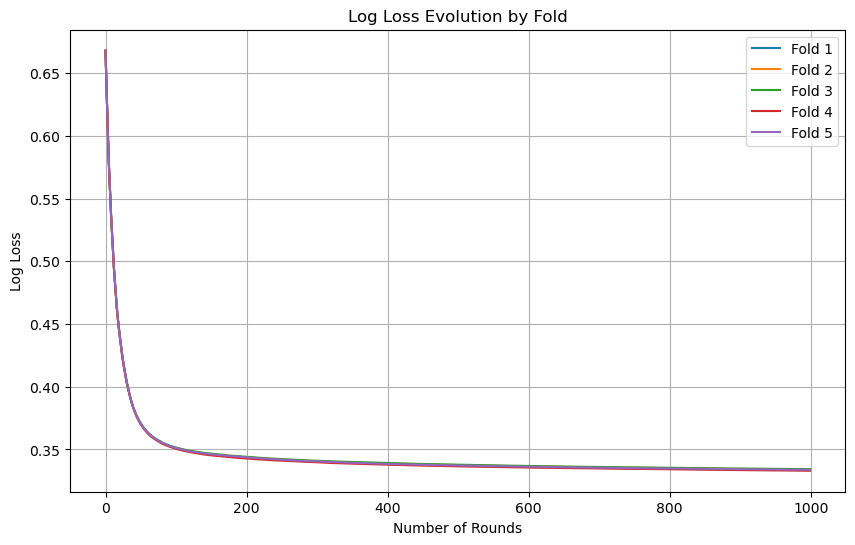

In [13]:
# Plot the log loss evolution by fold
plt.figure(figsize=(10, 6))
for fold, logloss in enumerate(logloss_values, start=1):
    plt.plot(logloss, label=f'Fold {fold}')
plt.xlabel('Number of Rounds')
plt.ylabel('Log Loss')
plt.title('Log Loss Evolution by Fold')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
xgb_model.save_model('xgboost_model.json')